# Backtest vectorizado y optimización de parametros con Pandas.

## Hackeado by J3viton (learning BackTesting 2021).

---

En este Notebook vamos a realizar un backtest de una estrategia sencilla. Se trata de un cruce de medias, que se puede considerar el "Hello World!" de los sistemas automáticos.

Vamos a usar el módulo Pandas, para realizar un backtest vectorizado, es decir calcular el resultado del backtest sin iterar sobre las filas (barras) de la serie temporal.

Posteriormente realizarmos una optimización de los parametros del sistema, y veremos como el calculo vectorizador nos permite hacer un gran número de backtests para la optimización en un tiempo muy breve.

---

# IMPORTACIÓN DE MODULOS Y CARGA DE DATOS


Como es usual, importamos los módulos que vamos a necesitar para las distintas tareas, y preparamos Matplotlib para una mejor visualización de los gráficos en el notebook.

Se importa un modulo llamado **analisis**, en realidad se trata de un archivo .py con algunas funciones de apoyo para el trabajo, debe estar guardado en la misma carpeta que este notebook.

In [2]:
import pandas as pd
import analisis   
import numpy as np
import itertools
import seaborn as sns
import yfinance as yf

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 18, 8
plt.style.use('ggplot')

from IPython.display import display, Markdown

Importamos el modulo **quandl** que nos proporcionará una descarga de los datos que vamos a necesitar, en este caso la cotización diaria de las acciones de Apple.  

In [3]:
# import quandl
# quandl.ApiConfig.api_key = "Aquí va tu API KEY" # Para una descarga ocasional no necesitas la API KEY.
# qd_data = quandl.get("WIKI/AAPL", start_date= "2000-01-01", end_date= "2018-06-15")

qd_data = yf.download('MTS.MC', '2010-1-1','2021-11-1')

[*********************100%***********************]  1 of 1 completed


Tambien puedes cargar los datos desde el archivo pickle.

In [4]:
# qd_data = pd.read_pickle('apple_qd.pkl')

Veamos la cabecera del dataframe que acabamos de crear con los datos descargados.

In [5]:
qd_data.head()

Open       High        Low      Close  Adj Close  Volume
Date                                                                     
2010-01-04  66.061111  69.420151  66.050934  69.420151  57.244827  453210
2010-01-05  68.748344  69.012993  67.089180  67.221504  55.431797  498327
2010-01-06  67.140076  67.262222  65.307869  66.895782  55.163193  314318
2010-01-07  67.058640  68.157967  66.447906  68.076530  56.136848  307631
2010-01-08  68.554939  68.911201  66.773636  68.442978  56.439037  306166

La tabla muestra que tenemos datos sin ajustar y ajustados. Tomaremos solo los datos OHLCV ajustados y el volumen, prescindiremos del resto de columnas, y eliminaremos el prefijo __Adj.__ para mas comodidad de uso.

Estudiar las posibildades de Python en vectorizado ...

In [6]:
ajustadas = [f for f in qd_data.columns if f.startswith('Adj')]  # guardamos una lista con las cabeceras de las columnas
qd_data = qd_data[ajustadas].copy()    # guardamos la tabla con las cabeceras selecionas arriba
qd_data.columns = [f[4:] for f in qd_data.columns]  #quitamos los literales
qd_data.head()

Close
Date                 
2010-01-04  57.244827
2010-01-05  55.431797
2010-01-06  55.163193
2010-01-07  56.136848
2010-01-08  56.439037

Para usarlo en nuestro backtest vamos a hacer una copia del dataframe pero solo hasta 2017.

In [7]:
data = qd_data[:-1].copy()

In [8]:
data.head()

Close
Date                 
2010-01-04  57.244827
2010-01-05  55.431797
2010-01-06  55.163193
2010-01-07  56.136848
2010-01-08  56.439037

---


# DEFINICION DEL SISTEMA

Es importante tener clara la lógica del sistema, pues debemos plasmarla de forma sencilla y correcta en el dataframe para realizar el backtest del mismo.

Esta estrategia utiliza dos medias simples del precio de cierre, de 20 y 60 periodos. Calculemoslas y asignamos sus valores a nuevas columnas de nuestro dataframe.

Para ello usamos la función **rolling** de Pandas, que va _rodando_ una ventana de N valores, sobre la que realiza un calculo, en este caso la media.

In [10]:
import regresionAMedia_v2


ModuleNotFoundError: No module named 'regresionAMedia_v2'

In [9]:
data.tail()

Close    SMA_20     SMA_60
Date                                      
2021-10-22  27.215000  26.27225  27.769083
2021-10-25  28.400000  26.39100  27.761083
2021-10-26  29.225000  26.58175  27.759917
2021-10-27  29.135000  26.74450  27.756250
2021-10-28  28.950001  26.87075  27.752250

Como lo que nos interesa es su cruce, para saber cuando se produce calcularemos la diferencia entre ambas medias para cada muestra. Y el signo de la diferencia será la señal para establecer la posición del sistema.

Así cuando la diferencia sea positiva, significará que la media de 20 periodos es mayor que la de 60 periodos, indicando una tendencia alcista y tomando una posición compradora. Con una diferencia negativa, la lógica es justo la inversa y tomaremos posicion vendedora.

In [10]:
data['Dif_SMA'] = data.SMA_20 - data.SMA_60
data['Senal'] = np.sign(data.Dif_SMA)

Para calcular los retornos del sistema, calculamos la diferencia relativativa entre el precio de cierre y el del día anterior. Para posteriormente multiplicarlo por la señal que del día anterior que nos indicaba la posición a tomar.

In [11]:
data['Dif_Close'] = data.Close.pct_change()  #calula el incremento porcentual desde la celda del dia anterior

data['Retornos'] = data.Dif_Close * data.Senal.shift(1)

In [12]:
data.tail()

Close    SMA_20     SMA_60   Dif_SMA  Senal  Dif_Close  \
Date                                                                     
2021-10-22  27.215000  26.27225  27.769083 -1.496833   -1.0   0.009084   
2021-10-25  28.400000  26.39100  27.761083 -1.370083   -1.0   0.043542   
2021-10-26  29.225000  26.58175  27.759917 -1.178167   -1.0   0.029049   
2021-10-27  29.135000  26.74450  27.756250 -1.011750   -1.0  -0.003080   
2021-10-28  28.950001  26.87075  27.752250 -0.881500   -1.0  -0.006350   

            Retornos  
Date                  
2021-10-22 -0.009084  
2021-10-25 -0.043542  
2021-10-26 -0.029049  
2021-10-27  0.003080  
2021-10-28  0.006350

El capital, por comodidad, lo calcularemos en base 100, es decir como si iniciaramos la inversión con 100 unidades monetarias. Para su calculo arrastramos el producto acumulado de los retornos mas 1, multiplicados como dijimos por 100.

In [13]:
data['Capital'] = (data.Retornos + 1).cumprod() * 100

Veamos como queda la tabla, tras añadir estas columnas.

Observamos de la fila 58 en adelante, pues hasta que no existen 60 filas no es posible calcular el SMA_60, y por tanto no tenemos señal para tomar posición.

In [14]:
data[:100]

Close     SMA_20     SMA_60   Dif_SMA  Senal  Dif_Close  \
Date                                                                      
2010-01-04  57.244816        NaN        NaN       NaN    NaN        NaN   
2010-01-05  55.431789        NaN        NaN       NaN    NaN  -0.031671   
2010-01-06  55.163193        NaN        NaN       NaN    NaN  -0.004846   
2010-01-07  56.136856        NaN        NaN       NaN    NaN   0.017651   
2010-01-08  56.439030        NaN        NaN       NaN    NaN   0.005383   
...               ...        ...        ...       ...    ...        ...   
2010-05-19  41.973011  48.519462  51.863587 -3.344125   -1.0  -0.051908   
2010-05-20  40.384655  47.901442  51.741081 -3.839639   -1.0  -0.037842   
2010-05-21  41.197872  47.311409  51.629172 -4.317763   -1.0   0.020137   
2010-05-24  40.499611  46.591415  51.523790 -4.932374   -1.0  -0.016949   
2010-05-25  39.469242  45.924667  51.394617 -5.469950   -1.0  -0.025441   

            Retornos     Capital  
Date                              
2010-01-04       NaN         NaN  
2010-01-05       NaN         NaN  
2010-01-06       NaN         NaN  
2010-01-07       NaN         NaN  
2010-01-08       NaN         NaN  
...              ...         ...  
2010-05-19  0.051908   96.670705  
2010-05-20  0.037842  100.328949  
2010-05-21 -0.020137   98.308646  
2010-05-24  0.016949   99.974876  
2010-05-25  0.025441  102.518382  

[100 rows x 8 columns]

Veamos gráficamente como evoluciona el precio y las dos medias.

In [15]:
data[['Close','SMA_20','SMA_60']].plot(color=['0.7','r','g'])
plt.show()

ImportError: matplotlib is required for plotting when the default backend "matplotlib" is selected.

Pero para observar gráficamente la evolución del sistema necesitamos un gráfico con mas información. Para ello definimos una función que nos mostrará un gráfico con la evolución de nuestra estrategia, comparandola con la del activo. En un subgráfico se visualizará el drawdown del sistema, comparado de nuevo con el del activo. Y por útlimo las posiciones que toma el sistema.

In [16]:
def grafico (df):
    estudio = df.copy()
    DD_bh, maxDD, maxDD_ini, maxDD_fin = analisis.DrawDown(estudio.Dif_Close[60:], info = False) 
    DD, maxDD, maxDD_ini, maxDD_fin = analisis.DrawDown(estudio.Retornos.fillna(0), info = False) 

    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(18, 12), gridspec_kw = {'height_ratios':[3, 1, 1]})
    fig.suptitle('Estrategia vs B & H', fontsize=20)

    ax1.plot(estudio.Capital.fillna(100))
    ax1.plot((estudio.Close) *100 / estudio.Close[0])
    ax1.set_title('Capital')
    ax1.legend(['Estrategia','Buy & Hold'])

    ax2.plot(DD*100, c='0.5')
    ax2.plot(DD_bh*100, c='y')
    ax2.fill_between(DD.index, 0, DD*100, color='0.7')
    ax2.set_title('Drawdown')
    ax2.legend(['Estrategia','Buy & Hold'])

    ax3.plot(estudio.Senal, c='orange')
    ax3.fill_between(estudio.index, 0, estudio.Senal*100, color='orange')
    ax3.set_title('Posición')

    plt.show()
    return

In [17]:
grafico(data)

NameError: name 'plt' is not defined

---

In [115]:
data['Dif_Open'] = data.Close.pct_change()
data['Posicion'] = data.Senal.shift(1)
data['Retornos'] = data.Posicion.shift(1) * data.Dif_Open
data['Capital'] = (data.Retornos.fillna(0) + 1).cumprod() * 100

In [116]:
data[55:70]

Close     SMA_20     SMA_60   Dif_SMA  Senal  Dif_Close  \
Date                                                                      
2010-03-22  52.381779  50.961551        NaN       NaN    NaN  -0.004016   
2010-03-23  53.344925  51.242048        NaN       NaN    NaN   0.018387   
2010-03-24  53.885632  51.540708        NaN       NaN    NaN   0.010136   
2010-03-25  55.837261  51.991443        NaN       NaN    NaN   0.036218   
2010-03-26  55.457088  52.403316  50.927176  1.476141    1.0  -0.006809   
2010-03-29  56.293510  52.833354  50.911321  1.922033    1.0   0.015082   
2010-03-30  55.000866  53.126101  50.904139  2.221962    1.0  -0.022963   
2010-03-31  54.722034  53.332247  50.896786  2.435461    1.0  -0.005070   
2010-04-01  56.944042  53.667237  50.910239  2.756997    1.0   0.040605   
2010-04-06  59.157604  54.022080  50.955549  3.066532    1.0   0.038873   
2010-04-07  58.684479  54.328767  51.007522  3.321245    1.0  -0.007998   
2010-04-08  57.214420  54.551813  51.060874  3.490938    1.0  -0.025050   
2010-04-09  57.586163  54.794290  51.119164  3.675126    1.0   0.006497   
2010-04-12  57.205975  55.060846  51.150692  3.910153    1.0  -0.006602   
2010-04-13  56.994743  55.283046  51.201083  4.081962    1.0  -0.003692   

            Retornos     Capital  Dif_Open  Posicion  
Date                                                  
2010-03-22       NaN  100.000000 -0.004016       NaN  
2010-03-23       NaN  100.000000  0.018387       NaN  
2010-03-24       NaN  100.000000  0.010136       NaN  
2010-03-25       NaN  100.000000  0.036218       NaN  
2010-03-26       NaN  100.000000 -0.006809       NaN  
2010-03-29       NaN  100.000000  0.015082       1.0  
2010-03-30 -0.022963   97.703742 -0.022963       1.0  
2010-03-31 -0.005070   97.208424 -0.005070       1.0  
2010-04-01  0.040605  101.155607  0.040605       1.0  
2010-04-06  0.038873  105.087787  0.038873       1.0  
2010-04-07 -0.007998  104.247325 -0.007998       1.0  
2010-04-08 -0.025050  101.635908 -0.025050       1.0  
2010-04-09  0.006497  102.296272  0.006497       1.0  
2010-04-12 -0.006602  101.620905 -0.006602       1.0  
2010-04-13 -0.003692  101.245673 -0.003692       1.0

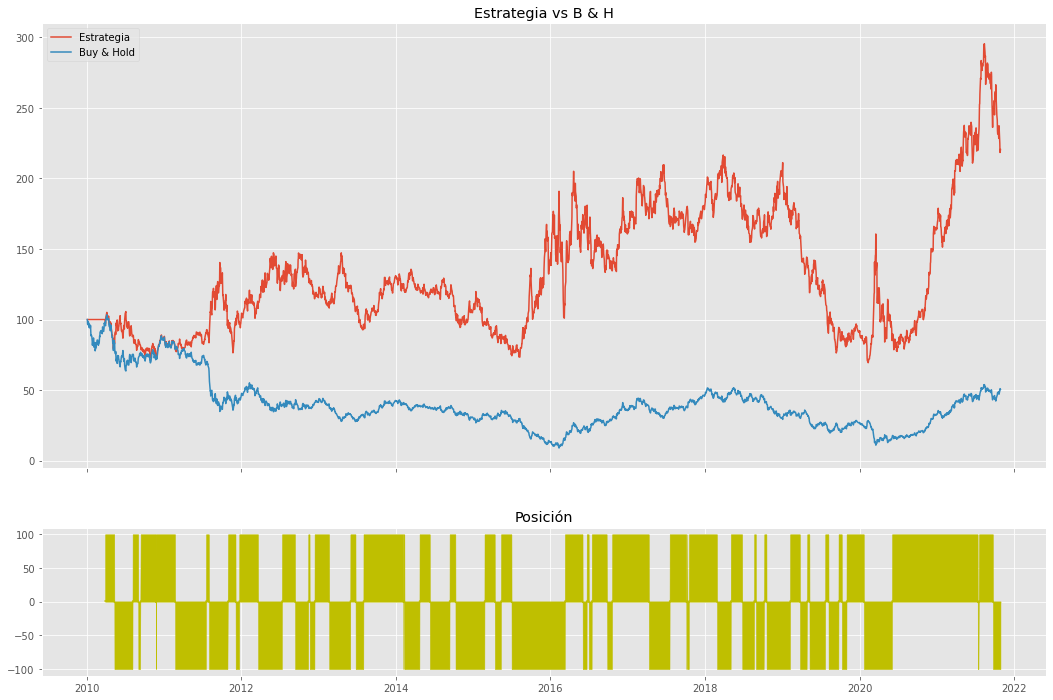

In [117]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(18, 12), gridspec_kw = {'height_ratios':[3, 1]})
ax1.plot(data.Capital)
ax1.plot(data.Close *100 / data.Close[0])
ax1.set_title('Estrategia vs B & H')
ax1.legend(['Estrategia','Buy & Hold'])
ax2.plot(data.Posicion, c='y')
ax2.fill_between(data.index, 0, data.Posicion*100, color='y')
ax2.set_title('Posición')
plt.show()

---

# ANALISIS DEL SISTEMA

In [118]:
Beneficio_Bruto = data.Capital[-1] - data.Capital[0]
print ('Beneficio Bruto : {:.2f}'.format(Beneficio_Bruto))

Beneficio Bruto : 120.41


In [119]:
CAGR = analisis.CAGR(data.Retornos)
print ('CAGR : {:.2f}%'.format(CAGR * 100))

CAGR : 6.91%


In [120]:
DD, maxDD, maxDD_ini, maxDD_fin = analisis.DrawDown(data.Retornos) 


Máximo Drawdown : 67.95% 
Inicio : 2018-03-28 
Fin    : 2021-04-16


In [121]:
Sharpe = CAGR / (np.log(data.Retornos + 1).std(skipna=True) * 252 ** 0.5)
print ('Sharpe : {:.3f}'.format(CAGR ))

Sharpe : 0.069


--------------------------------------------------------------------

---------------------------------------------------------------

---

# OPTIMIZACION DEL SISTEMA

In [68]:
op_data = qd_data[:'2016'].copy()
op_data['Dif_Close'] = op_data.Close.pct_change()
op_data['Dif_Open'] = op_data.Close.pct_change()  #era Open

In [69]:
def estrategia_medias (df, periodo_rapido, periodo_lento):
    
    estr = df.copy()
    estr[f'SMA_{periodo_rapido}'] = estr.Close.rolling(periodo_rapido).mean()
    estr[f'SMA_{periodo_lento}'] = estr.Close.rolling(periodo_lento).mean()
    estr['Dif_SMA'] = estr[f'SMA_{periodo_rapido}'] - estr[f'SMA_{periodo_lento}']    
    estr['Senal'] = estr.Dif_SMA / estr.Dif_SMA.abs()
    estr['Posicion'] = estr.Senal.shift(1)    
    estr['Retornos'] = estr.Posicion.shift(1) * estr.Dif_Open    
    estr['Capital'] = (estr.Retornos+1).cumprod() * 100
    
    resultados = {'Rapida' : periodo_rapido, 'Lenta' : periodo_lento}
    resultados['Beneficio Bruto'] = round(estr.Capital[-1]-100,2)
    resultados['CAGR'] = analisis.CAGR(estr.Retornos) 
    resultados['Sharpe'] = resultados['CAGR'] / (np.log(estr.Retornos + 1).std(skipna=True) * 252 ** 0.5)
    resultados['Máximo Drawdown'] = (estr.Capital.div(estr.Capital.cummax()).sub(1)).min()
    
    resultados['Número de trades'] = (np.sign(estr.Posicion * estr.Posicion.shift(1)) == -1).sum() 
    
    return estr, resultados

In [70]:
periodos_rapido = range (5,160,5)
periodos_lento = range (20,210,5)


In [71]:
%%time

coleccion = {}
resultados = {}

for periodo_rapido in periodos_rapido:
    for periodo_lento in periodos_lento:

        
        if periodo_lento <= periodo_rapido:
            continue
        estr, resultado = estrategia_medias (op_data, periodo_rapido, periodo_lento)
        nombre = f'estrategia_{periodo_rapido}_{periodo_lento}'
        coleccion[nombre] = estr
        resultados[nombre] = resultado


Wall time: 7.51 s


In [72]:
print ('Realizados {} backtests sobre una serie de {} muestras'.format(len(coleccion), op_data.shape[0]))

Realizados 772 backtests sobre una serie de 4278 muestras


In [73]:
clasificacion = pd.DataFrame(resultados).transpose()
clasificacion.head(25)

Rapida  Lenta  Beneficio Bruto      CAGR    Sharpe  \
estrategia_5_20      5.0   20.0            20.24  0.010897  0.026217   
estrategia_5_25      5.0   25.0             8.00  0.004533  0.010920   
estrategia_5_30      5.0   30.0           -20.76 -0.013589 -0.032741   
estrategia_5_35      5.0   35.0            15.36  0.008436  0.020330   
estrategia_5_40      5.0   40.0           229.51  0.072613  0.175037   
estrategia_5_45      5.0   45.0           380.12  0.096614  0.233894   
estrategia_5_50      5.0   50.0           251.97  0.076779  0.185845   
estrategia_5_55      5.0   55.0           309.25  0.086367  0.209314   
estrategia_5_60      5.0   60.0           952.88  0.148421  0.360154   
estrategia_5_65      5.0   65.0          1564.72  0.179770  0.437257   
estrategia_5_70      5.0   70.0           945.27  0.147932  0.360163   
estrategia_5_75      5.0   75.0           902.35  0.145105  0.354377   
estrategia_5_80      5.0   80.0           824.31  0.139662  0.341512   
estrategia_5_85      5.0   85.0           150.73  0.055522  0.127706   
estrategia_5_90      5.0   90.0            69.83  0.031623  0.072771   
estrategia_5_95      5.0   95.0           111.56  0.045035  0.103774   
estrategia_5_100     5.0  100.0           100.47  0.041733  0.096256   
estrategia_5_105     5.0  105.0           148.50  0.054969  0.126843   
estrategia_5_110     5.0  110.0           809.46  0.138577  0.340123   
estrategia_5_115     5.0  115.0           705.45  0.130478  0.320369   
estrategia_5_120     5.0  120.0          1021.83  0.152712  0.376060   
estrategia_5_125     5.0  125.0           842.34  0.140957  0.347627   
estrategia_5_130     5.0  130.0           805.32  0.138272  0.341019   
estrategia_5_135     5.0  135.0          1071.63  0.155659  0.384153   
estrategia_5_140     5.0  140.0          1119.35  0.158374  0.391192   

                  Máximo Drawdown  Número de trades  
estrategia_5_20         -0.781917             260.0  
estrategia_5_25         -0.780742             223.0  
estrategia_5_30         -0.795322             204.0  
estrategia_5_35         -0.717523             178.0  
estrategia_5_40         -0.741206             172.0  
estrategia_5_45         -0.638408             164.0  
estrategia_5_50         -0.699468             146.0  
estrategia_5_55         -0.602437             130.0  
estrategia_5_60         -0.581561             120.0  
estrategia_5_65         -0.652979             112.0  
estrategia_5_70         -0.665623             120.0  
estrategia_5_75         -0.686159             113.0  
estrategia_5_80         -0.641140             110.0  
estrategia_5_85         -0.885757             106.0  
estrategia_5_90         -0.884173              95.0  
estrategia_5_95         -0.882857              87.0  
estrategia_5_100        -0.867030              79.0  
estrategia_5_105        -0.858520              79.0  
estrategia_5_110        -0.644527              77.0  
estrategia_5_115        -0.676929              71.0  
estrategia_5_120        -0.542010              71.0  
estrategia_5_125        -0.667807              71.0  
estrategia_5_130        -0.715132              69.0  
estrategia_5_135        -0.632552              58.0  
estrategia_5_140        -0.635395              56.0

In [74]:
pd.DataFrame(clasificacion['Beneficio Bruto'].sort_values(ascending=False).head(10))

Beneficio Bruto
estrategia_50_55            6615.24
estrategia_5_185            3251.85
estrategia_135_160          2443.57
estrategia_5_180            2418.82
estrategia_10_205           2357.16
estrategia_55_60            2324.91
estrategia_5_175            2162.91
estrategia_125_160          2150.97
estrategia_50_65            2141.46
estrategia_5_190            2001.73

In [75]:
pd.DataFrame(clasificacion.Sharpe.sort_values(ascending=False).head(10))

Sharpe
estrategia_50_55    0.682173
estrategia_5_185    0.570860
estrategia_10_205   0.538673
estrategia_5_180    0.518784
estrategia_135_160  0.517248
estrategia_5_190    0.506416
estrategia_55_60    0.501224
estrategia_5_175    0.499197
estrategia_125_160  0.495954
estrategia_50_65    0.488923

In [76]:
pd.DataFrame(clasificacion['Máximo Drawdown'].sort_values(ascending=False).head(10))

Máximo Drawdown
estrategia_5_120        -0.542010
estrategia_45_55        -0.545070
estrategia_55_60        -0.563602
estrategia_45_70        -0.567855
estrategia_50_70        -0.575904
estrategia_5_60         -0.581561
estrategia_45_65        -0.594283
estrategia_50_55        -0.598843
estrategia_50_65        -0.599843
estrategia_5_55         -0.602437

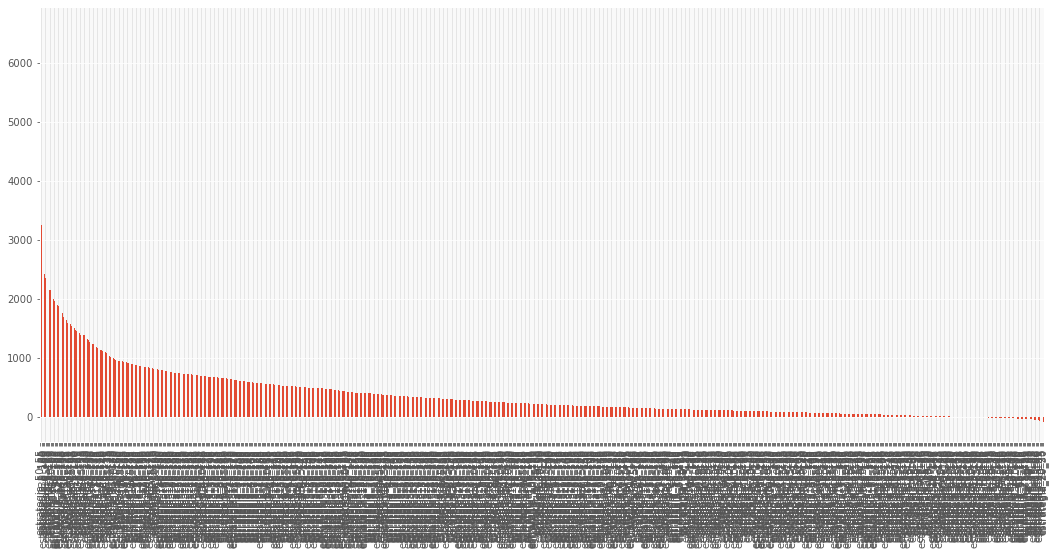

In [77]:
clasificacion['Beneficio Bruto'].sort_values(ascending=False).plot(kind='bar')

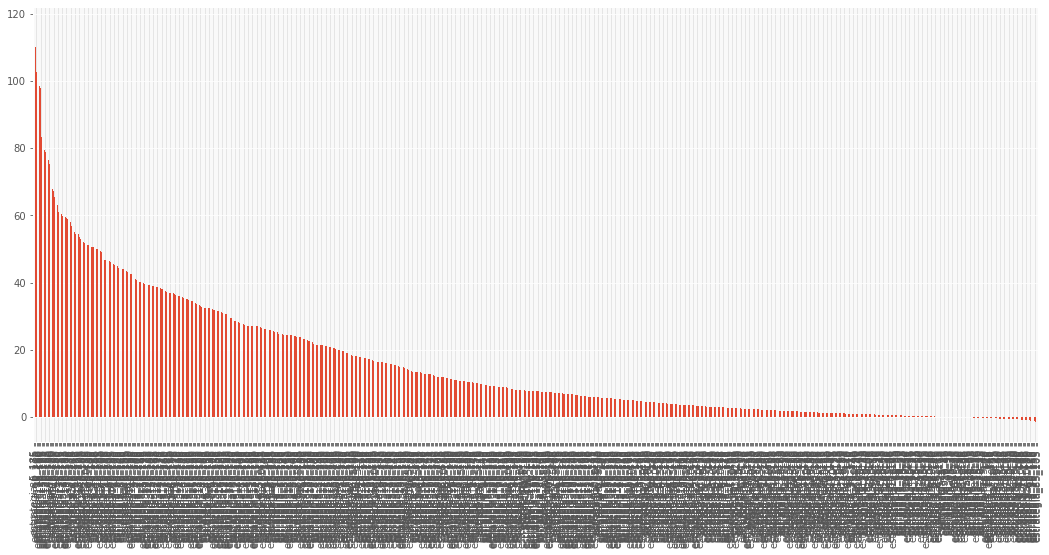

In [78]:
(clasificacion['Beneficio Bruto']/clasificacion['Número de trades']).sort_values(ascending=False).plot(kind='bar')

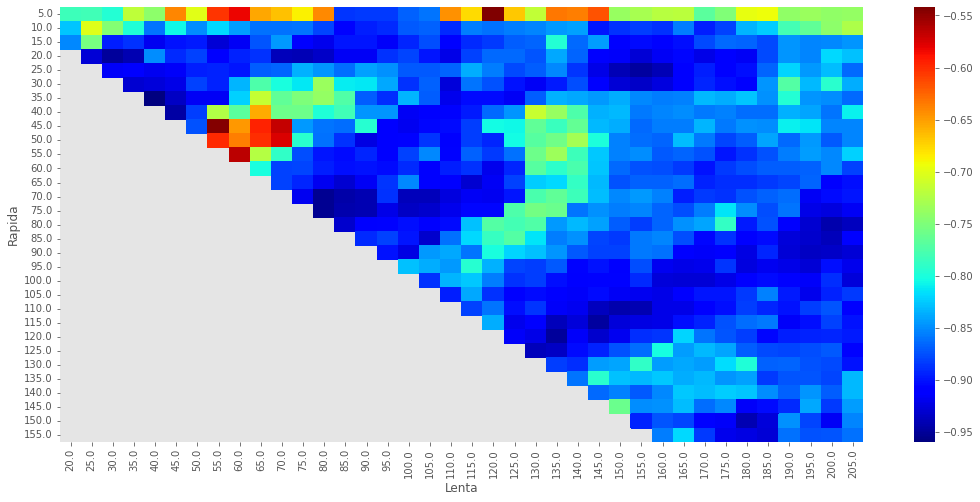

In [79]:
ax=sns.heatmap(clasificacion.pivot('Rapida','Lenta','Máximo Drawdown'), annot=False, fmt=".3", linewidths=0, cmap=plt.cm.jet)

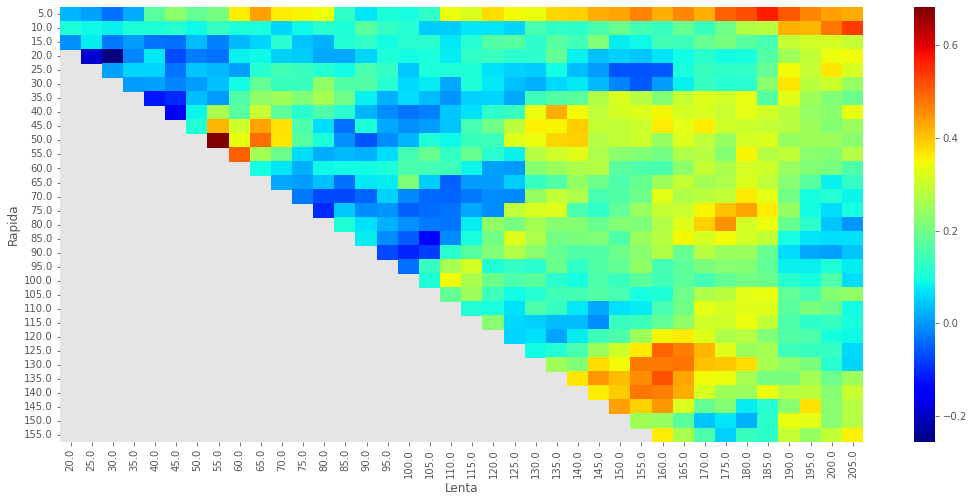

In [80]:
# ax=sns.heatmap(clasificacion.pivot('Rapida','Lenta','Sharpe'), annot=True, fmt=".3f", cmap=plt.cm.jet)
ax=sns.heatmap(clasificacion.pivot('Rapida','Lenta','Sharpe'), annot=False, fmt=".1f", cmap=plt.cm.jet )

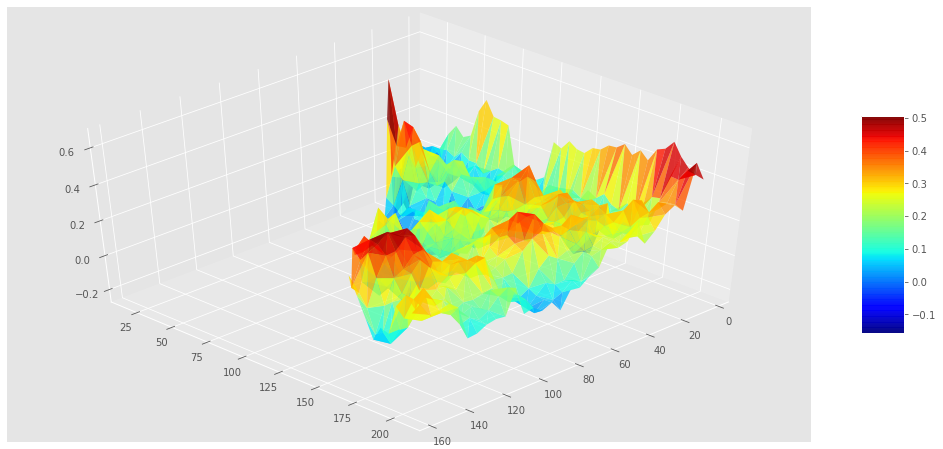

In [81]:
analisis.trisurf_heatmap (clasificacion, 'Rapida', 'Lenta','Sharpe', v1=45, v2=45)

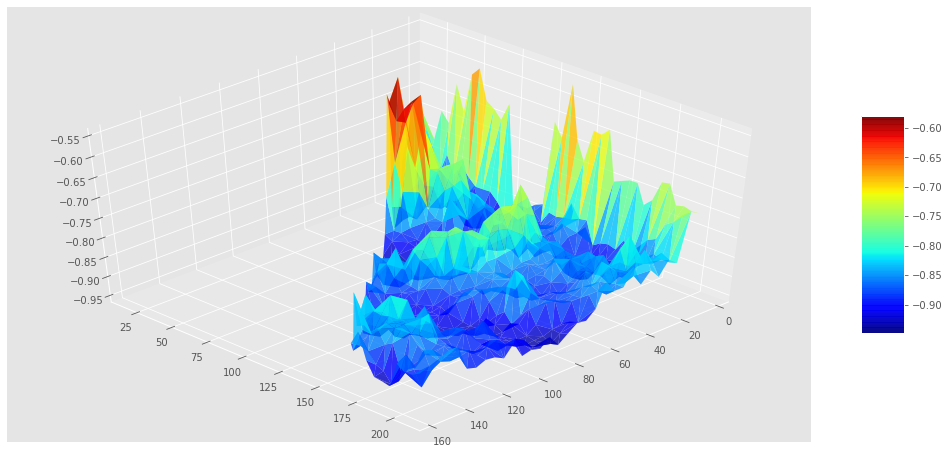

In [82]:
analisis.trisurf_heatmap (clasificacion, 'Rapida', 'Lenta','Máximo Drawdown',v1= 45, v2=45)

---

# REVISIÓN DE LOS PARÁMETROS SELECCIONADOS

In [83]:
pd.DataFrame(clasificacion.loc['estrategia_5_140'])

estrategia_5_140
Rapida                    5.000000
Lenta                   140.000000
Beneficio Bruto        1119.350000
CAGR                      0.158374
Sharpe                    0.391192
Máximo Drawdown          -0.635395
Número de trades         56.000000

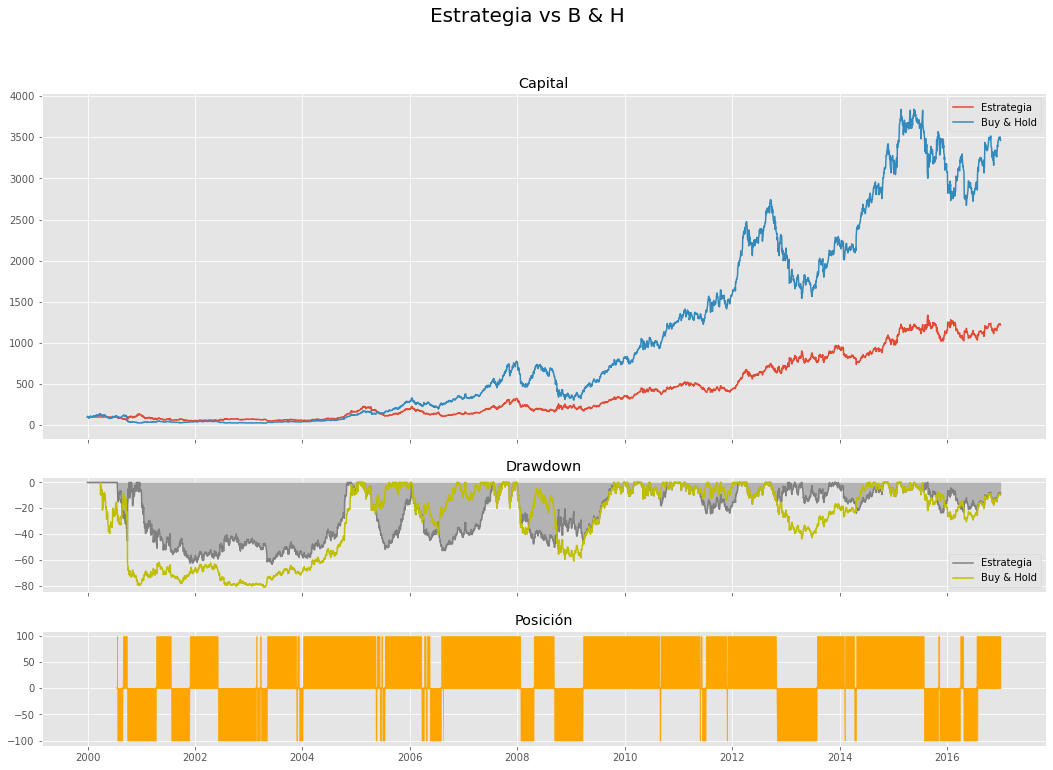

In [84]:
grafico(coleccion['estrategia_5_140'])


---


# PRUEBA FUERA DE LA MUESTRA

In [85]:
periodo_rapido = 5

periodo_lento = 140

out_sample= qd_data[data.shape[0]:].copy()

out_sample['Dif_Close'] = out_sample.Close.pct_change()
out_sample['Dif_Open'] = out_sample.Close.pct_change()  #era Cloe


out_estr, out_resultado = estrategia_medias (out_sample, periodo_rapido, periodo_lento)


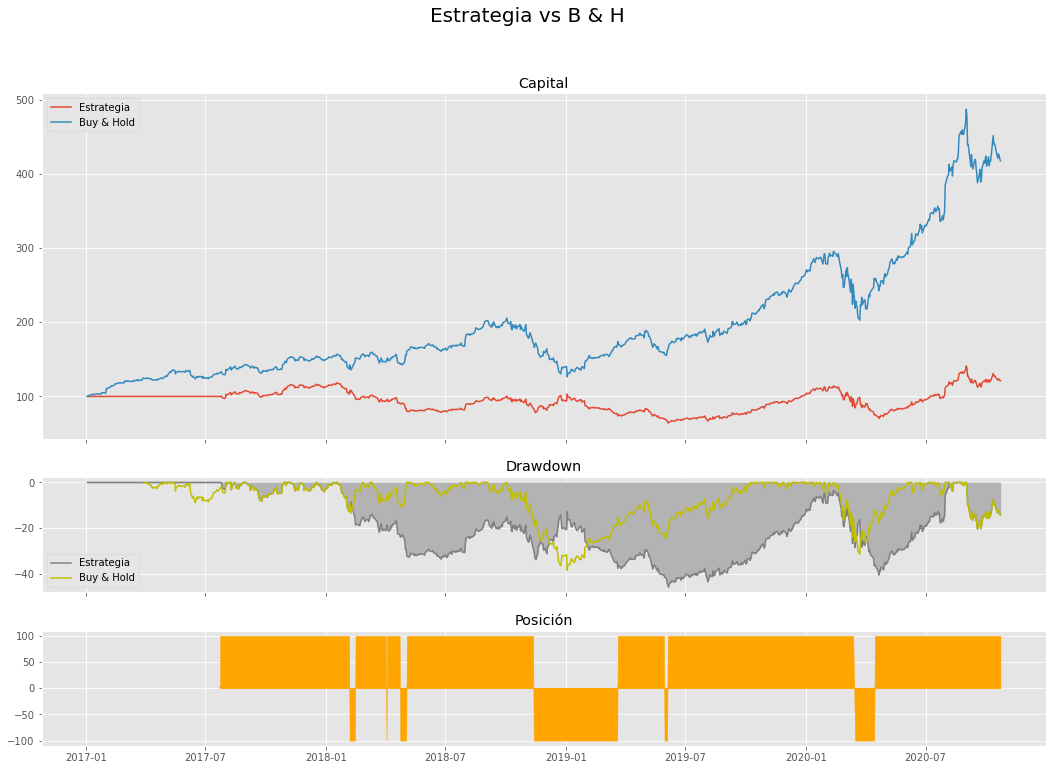

In [86]:
grafico(out_estr)

---